# Detailed balance limit for power conversion efficiency of solar cells

$$\require{mhchem}$$  Author: Joel W. Ager (jwager@lbl.gov), [Group website](http://ager.mse.berkeley.edu), [github](https://github.com/joelager)  

**Overview of the detailed balance limit for the power conversion efficiency of solar cells** 
* Cell needs to have a minimum $J_{sat}$ corresponding to a recombination current which will radiate a 300 K effective black body spectrum back to the universe (otherwise cell will heat up)  
* It possible to think about this as expelling entropy to increase entropy of universe as required by 2nd Law  
* The radiative recombination current depends on band gap because a perfect PV absorber can only absorb light above its bandgap - so the radiative recombination current is related to the tail of the Planck law distribution for wavelengths shorter than the band gap.  
* Diode equation can arise from general considerations of chemical solar cell, see other notebook. 

**In this notebook**

An analysis of the famous paper which derived the detailed balance "Shockley-Queisser" limit for the power conversion efficiency of semiconductor-based solar cells
> Shockley, W.; Queisser, H. J. Detailed Balance Limit of Efficiency of P‐n Junction Solar Cells. [J. Appl. Phys. 1961, 32, 510–519](https://doi.org/10.1063/1.1736034).

# Import

In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [2]:
# SI basic units
meter, sec, mol, coul, volt, kelvin, kg = 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

In [3]:
## Derived units
amp    = coul*sec**-1 
joule  = kg * meter**2 * sec**-2
watt = kg*meter**2*sec**-2
Pa     = kg*meter**-1*sec**-1
eV     = 1.60217662e-19*joule


# Unit conversions
km     = 1e3*meter
cm     = 10**-2 * meter 
mm     = 10**-3 * meter 
micron = 10**-6 * meter 
nm     = 10**-9 * meter 
liter  = 1000*cm**3 
mC     = 1e-3    # implied coulomb here
mA     = 10**-3 * amp 
mV     = 10**-3 * volt 
minute = 60.0 * sec 
hour   = 3600.0  * sec 
kPa    = 1e3*Pa
bar    = 1e5*Pa
kJ     = 10**3*joule 
meV    = 1e-3*eV
μmol   = 1e-6*mol
mW     = 1e-3*watt

molar  = mol/liter 
mM     = 1e-3*molar
μM     = 1e-6*molar

## Physical constants
R      = 8.3144598                # in SI units, J mol-1 K-1
q      = 1.60217662*10**-19       # Elementary charge
NA     = 6.02214076*10**23        # Avogadro number
F      = NA*q                     # Faraday constant
kB     = R/NA                     # Boltzmann constant
hbar   = 1.0545718*10**-34*meter**2*kg*sec**-1 
h      = hbar*2*np.pi
c      = 299792458*meter*sec**-1
me     = 9.10938356e-31*kg

# Shockley-Queisser (detailed balance) limit

In this pioneering 1961 [paper](https://doi.org/10.1063/1.1736034), Shockley and Queisser derive the detailed balance limit for the power conversion efficency of solar cells.  

The paper can be a bit difficult to follow as they use what is now considered non-standard notation. In this notebook section the orginal notation of the paper is used.  

Interestingly, they anticipate other power conversions effects, such as carrier multiplication and power generation by the cold sky.  
> *Once a photon exceeds about three times the energy gap $E_g$, the probability of producing two or more hole-electron pairs becomes appreciable, Vavilov, J. Phys. Chem.  Solids 8, 223 (1959) and Tauc, J. Phys. Chem. Solids 8, 219 (1959). The effect would slightly increase the possible quantum efficiency; however, we shall not consider it futher in this article.*

> *If the cell is surrounded by cold space, it will generate a small open-ciruit reverse voltage.*

They use a 6000 K black body source, which is brighter than AM1.5G and also has more IR photons which cannot be absorbed. So the limit calculated using AM1.5G will be higher. One reason that they did this is that, at the time, it was quite tedious do the integrals over the Planck distribution, see this [SPIE article](https://doi.org/10.1117/12.932274) for a history of these types of specialized slide rules used for this purpose.  
> *A convenient aid to such calculations is a slide ride manufactured by A. G. Thorton, Ltd., Manchester, England. It is described by Makowski, Rev. Sci. Instr. 20, 884 (1949).*

**Carnot limit for conversion from a 6000 K heat source**

The Carnot limit of any heat engine, the difference in temperature between the hot working fluid — such as the steam in a power plant — and its cooled-off temperature as it leaves the engine, divided by the temperature in degrees Kelvin of the hot fluid:
    
$$\frac{T_{sun} - T_{cell}}{T_{sun}}$$

This is about 95% for 6000 K sun and 300 K solar cell.

In [4]:
(6000-300)/6000

0.95

**Statement of the detailed balance limit**

*Radiative recombination sets an upper limit to the minority carrier lifetime. The lifetimes due to this effect have been calculated using the principle of detailed balance. It is this radiative recombination that determines the detailed balance limit for efficiency. If the radiative efficiency is only a fraction $f_c$ of all the recombination, then the efficiency is substantially reduced below the detailed balance limit.*

There are three solar cell cases in the paper

1.  Ultimate efficiency per Shockely and Queisser.  Cell is at 0 K. This is complete absorption all all photons above the bandgap and, because the cell is at 0 K, no losses.  Geometry is a spherical cell at 0 K surrounded by a BB source at 6000 K.
2.  Detailed balance or limiting efficiency.  There is a second calculation in SQ.  It is the spherical cell but at 300 K, so there is recombination loss.  
3.  Detailed balance limit for a 1 sun planar cell. This provides the 31% value usually quoted.

**Notes on recombination**  
The detailed balance (radiative limit) is based on the idea the that solar cell must support a radiative recombination rate that will produce an outgoing energy flux equal to that of a blackbody at the cell temperature. This calcuated by equating the black body radiation law with calculation of the current corresponding to recombination producing photons at and above the band gap of the material.  

## Planck radiation law

From [Wikipedia](https://en.wikipedia.org/wiki/Planck%27s_law)

*Planck Law*  
As a function of frequency. Spectral radiance $B_{\nu}$ in units of W sr$^{-1}$ m$^{-2}$ Hz$^{-1}$

$$B_{\nu}(\nu, T) = \frac{2 h \nu^3}{c^2} \frac{1}{\exp(h \nu/k_B T)-1}$$

As a function of wavelength. Spectral radiance $B_{\lambda}$ in units of W sr$^{-1}$ m$^{-2}$ m$^{-1}$

$$B_{\lambda}(\lambda, T) = \frac{2 h c^2}{\lambda^5} \frac{1}{\exp(h c/\lambda k_B T)-1}$$

$$\frac{B_{\lambda}(\lambda, T) }{B_{\nu}(\nu, T)} = \frac{c}{\lambda^2} = \frac{\nu^2}{c}$$  

(I think) As a function of frequency in terms of phonon flux obtained by dividing $B_{\nu}$ by $h \nu$, units of sr$^{-1}$ m$^{-2}$ Hz$^{-1}$

$$\phi_{\nu}(\nu, T) = \frac{2  \nu^2}{c^2} \frac{1}{\exp(h \nu/k_B T)-1}$$


*Stefan-Boltzmann law*  
Integrate $B_{\nu}$ over $\nu$ and over a hemisphere corresponding to a flat emitter. The total power emitted per unit area at the surface of a black body ($P_s$) is a function of $T$ only and has SI units of W m$^{-2}$ K$^{-4}$:

$$P_s = \frac{2 k_B^4 \pi^5}{15 c^2 h^3}T^4 = \sigma T^4$$

where $\sigma$ is the Stefan-Boltzmann constant. 

In [5]:
# sigma in SI units
(2*kB**4*np.pi**5)/(15*c**2*h**3)

5.6703670160339343e-08

## Ultimate efficiency with spherical cell at 0 K

*There is an ultimate efficiency for any device employing a photoelectric process which has a single cutoff frequency $\nu_g$*  

*We shall assume that some means not indicated in the figure are present for maintaining the solar cell at temperature $T_c = 0$ so that only steady state conditions need be considered*

I would generalize this to say that it applies to all devices which support a single endergonic, light-driven reaction, with the creation of electrons and holes by above-bandgap light being one case.  

They consider a case of a solar cell at 0 K (no recombination is not necessary at equilibrium) surrounded by the sun at 6000 K. 

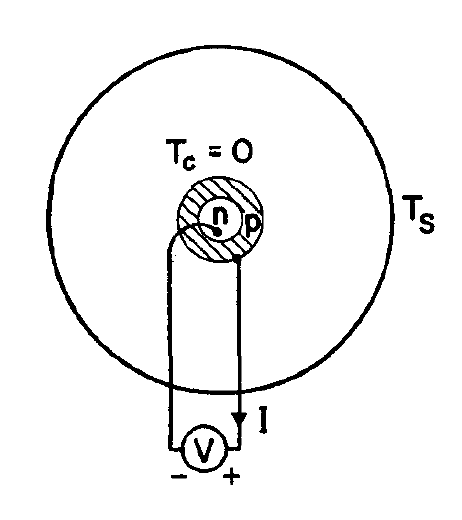

The chemical reaction is:

$$\ce{h \nu <=> e- + h+} \quad \Delta \mu = E_G = \frac{h \nu_g}{q} $$

Idea of a chemical solar cell can be used:  
> Work can be done by extracting electrons and holes at selective contacts  
> At equilibrium in the dark the chemical potential of the electrons and holes outside the cell would be 0 because they would be at zero concentration inside the cell  
> Under illumination flux out would equal generation rate with each electron and hole pair carrying $h \nu_g$ of energy  
> Cell might behave as an ideal current source as there is no recombination pathway. 
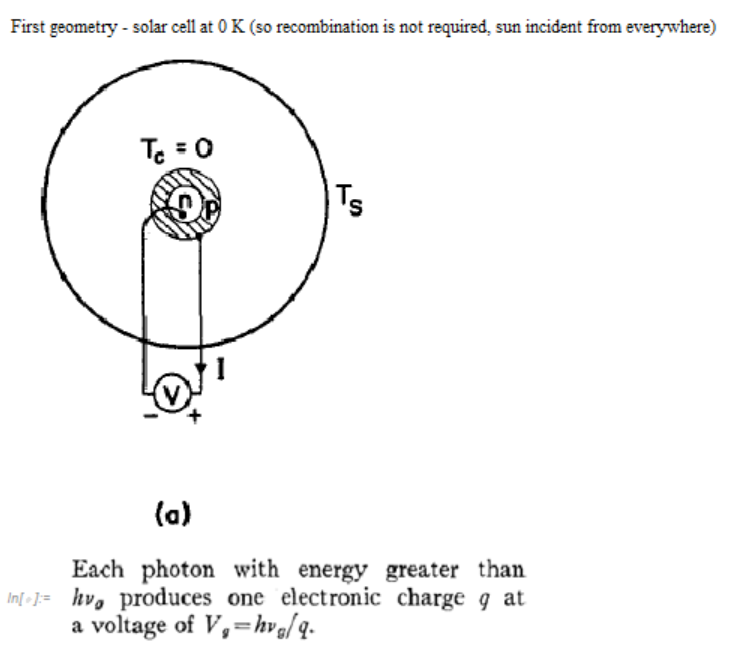

*Number of photons per second incident on the cell with energy above the band gap*

$$Q_s \equiv Q_s(\nu_g, T_s) = \frac{2 \pi}{c^2} \int_{\nu_g}^{\infty} \frac{\nu^2}{\exp(h \nu/k_B T_s)-1} d \nu$$

where $Q_s = B_{\nu}/h \nu$ converting spectral irradiance to photon flux (where does $\pi$ come from?).

Making the substitution $x = h \nu/k_B T_s$ and setting $h \nu_g = E_g$ ($x_g = E_g/k_B T_s$) and $x_c = T_c/T_s$, 

$$ Q_s = \frac{2 \pi (k_B T_{sun})^3/}{h^3 c^2} \int_{E_g/k_B T_{sun}}^{10 E_g/k_B T_{sun}} \frac{x^2}{\exp(x)-1} dx \tag{2.2}$$

Output power will be:

$$h \nu_g A Q_S$$

Denominator is the black body power density corresponding to the surface of the sun at 6000 K. 

$$ P_s = \frac{2 \pi^5(k_B T_{sun})^4)}{15 h^3*c^2} = \sigma T_{sun}^4 \tag{2.6}$$

In [6]:
T_cell = 300*kelvin
T_sun = 6000*kelvin

print('kBT on the surface of the sun {:.3f} V'.format(kB*T_sun/q))
print('kBT on the surface of the earth {:.5f} V'.format(kB*T_cell/q))

kBT on the surface of the sun 0.517 V
kBT on the surface of the earth 0.02585 V


In [7]:
def Qs(Eg):
    """
    Photon flux above the bandgap for illumination by a black body
    """
    lower_limit = Eg/(kB*T_sun)
    upper_limit = 10*Eg/(kB*T_sun)
    factor = (2*np.pi*(kB*T_sun)**3)/(h**3*c**2)
    integral = integrate.quad(lambda x: x**2/(np.exp(x) - 1), lower_limit, upper_limit)[0]
    return factor*integral

P_s = (2*np.pi**5*(kB*T_sun)**4)/(15*h**3*c**2)   # Stefan-Boltzmann power density

def η_ultimate(Eg):
    """
    Ultimate power conversion efficiency for a 0 K solar cell
    surrounded by a 6000 K blackbody
    """
    η = (Eg*Qs(Eg)/P_s)
    return η

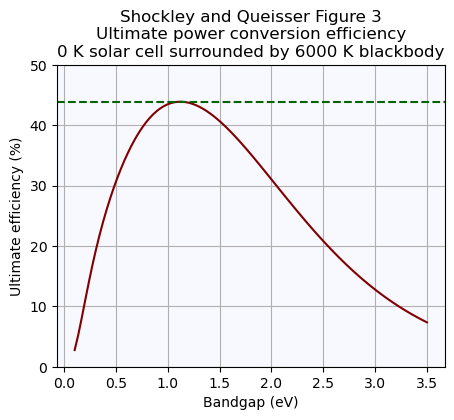

Limiting efficiency is 43.9%


In [8]:
Eg_plot = np.linspace(0.1, 3.5, 100)

fig, ax = plt.subplots(dpi=100, figsize=(5,4))
plt.title('Shockley and Queisser Figure 3\n'
          'Ultimate power conversion efficiency\n0 K solar cell surrounded by 6000 K blackbody')
ax.plot(Eg_plot, [η_ultimate(Eg*eV)*100 for Eg in Eg_plot], 'maroon' )
ax.set_xlabel('Bandgap (eV)')
ax.set_ylabel('Ultimate efficiency (%)')
ax.set_ylim(0,50)
ax.axhline(y=43.87, linestyle='--', color='darkgreen')
ax.grid()
ax.set_facecolor('ghostwhite')
plt.show()
print('Limiting efficiency is 43.9%')

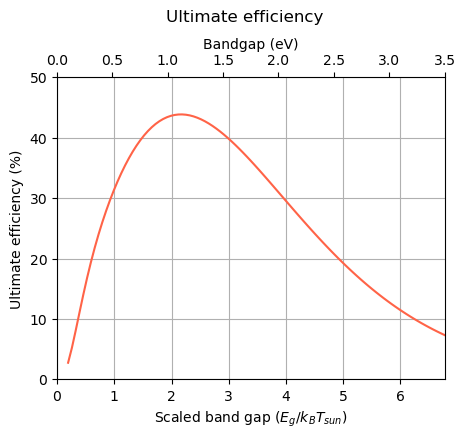

Max ultimate efficiency is found for a bandgap about 2x the thermal energy of the surface of the sun


In [9]:
from mpl_toolkits.axes_grid1.parasite_axes import SubplotHost   # new version

fig = plt.figure(figsize=(5,4), dpi=100)

fig.suptitle('Ultimate efficiency', y = 1.05)
ax1 = SubplotHost(fig, 111)
fig.add_subplot(ax1)

ax1.plot((Eg_plot*eV)/(kB*T_sun), [100*η_ultimate(Eg*eV) for Eg in Eg_plot], 'tomato' )
ax1.set_xlabel('Scaled band gap ($E_g/k_B T_{sun}$)')
ax1.set_ylabel('Ultimate efficiency (%)')
ax1.set_xlim(0, max(Eg_plot*eV)/(kB*T_sun))
ax1.set_ylim(0, 50)
ax1.grid()

ax2=ax1.twiny() # ax2 is responsible for "top" axis and "right" axis
#ax2.tick_params(direction='in')
#tticks=np.array([20.,30.,50.,100.,300.])
#ax2.set_xticks( [ 1000/t for t in tticks ] )
#ax2.set_xticklabels(tticks)
ax2.set_xlim(0, 3.5)
ax2.axis["top"].label.set_visible(True)
ax2.set_xlabel('Bandgap (eV)', y=1.01)
#ax2.set_yticks([])
plt.show()

print('Max ultimate efficiency is found for a bandgap about 2x the thermal energy of the surface of the sun')

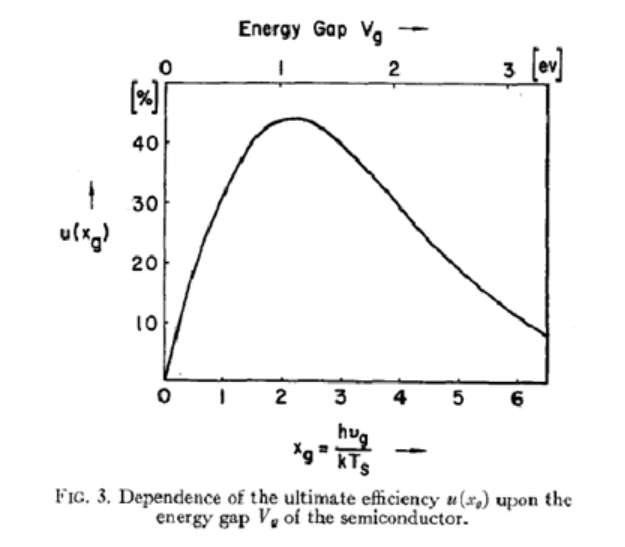

## Solar cells at finite temperature

*... we shall consider a solar cell subjected to radiation from the sun which is considered to subtend a small angle as represented [below]*  

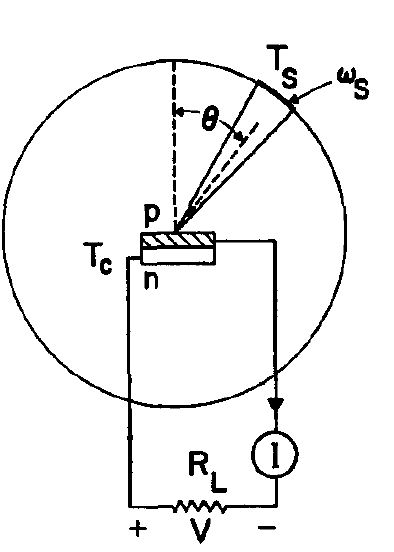

*In order to carry out the calculation, five processes must be considered:*
1.  $F_s$, generation rate of electron hole pairs by the incident light  
2.  $F_c$, radiative recombination of e-h pairs  
3.  Other non-radiative processes that generate  
4.  Other non-radiative processes that recombine  
5.  removal of holes from p-type and electrons from n-type (e.g. the photocurrent)  

Steady state current voltage relationship is determined by by finding conditions which makes the sum of these processes equal to zero.  

**generation rate due to solar radiation from a surrounding black body at the same temperature as the cell**

This is the crucial step that allows one to derive the mimimum reverse saturation current. 

$$F_{c0} = A t_c Q_s(\nu_g, T_c) \tag{3.1}$$

where  
$A$ is cell area (this will be $2 A_p$ for a flat cell)   
$t_c$ is probability that incident photon will make an electron-hole pair  
$Q_s$ is defined above, depends on bandgap and temperature of the wall

**generation rate due to solar radiation from a finite solid angle**

$$F_s = A f_\omega t_s Q_s \tag{3.2}$$

where
$A$ is cell area exposed to the sun    
$f_\omega$ is a geometric factor less than 1, is 6-e5 sr for the sun   
$t_s$ is probability that incident photon will make an electron-hole pair  
$Q_s$ is defined above, generation rate if the sun completely surrounded the cell

**geometrical factor**  
$f_\omega$ depends on the solid angle subtended by the sun ($\omega_s$) and the angle of incidence $\theta$ of its light on the solid cell. 

Solid angle of an area $A$ located on a sphere of radius $r$ is $A/r^2$

The solid angle subtended by the sun is:  
$$\omega_s = \frac{\pi (D/2)^2}{L^2} = \frac{\pi}{4} \frac{D^2}{L^2} \tag{3.3}$$

where $D$ is diamter of sun and $L$ is distance to it. As calculated below $\omega_s \approx 6.84 \times 10^{-5}$ sr

If the solar cell would be a sphere:  
> $f_\omega = \omega_s/4 \pi$  

For a flat cell (more realistic) compute the projected area $A_p$ (noting that total area of cell is $2A_p$, used when computing its black body radiation).  In this case  
> $f_\omega = \omega_s \cos \theta/ \pi$  
> power incident on cell = $A_p f_\omega P_s$ 

This will integrate to $A_p P_s$ over a hemisphere of $2 \pi$ steradians, "as it should." 

So for normal incidence, incident power is $A_p P_s f_\omega$

In [10]:
# Geometry of the earth and sun
sun_diameter = 1.39e6*km
sun_distance = 149e6*km

ω_sun = np.pi*(sun_diameter/sun_distance)**2*(1/4)     # solid angle subtended by sun

print(f'Solid angle subtended by sun is {ω_sun:.02e} steradians')

# For a flat cell at normal incidence
f_ω = ω_sun/np.pi
print(f'Geometical factor f_ω for a flat cell at normal incidence: {f_ω:.02e}')

print(f'Incident power (6000 K black body) for a flat cell at normal incidence: {P_s*f_ω:.02f} watt/m^2')
print('Compare solar constant of 1388 watt/m^2 (AM0)')

Solid angle subtended by sun is 6.84e-05 steradians
Geometical factor f_ω for a flat cell at normal incidence: 2.18e-05
Incident power (6000 K black body) for a flat cell at normal incidence: 1598.87 watt/m^2
Compare solar constant of 1388 watt/m^2 (AM0)


**Key statement of detailed balance** 

Equilibrium (no sun).   
*For the case in which the battery is equilibrium and surrounded by a blackbody of temperature $T_c$, the rate of emission of photons due to recombination must be exactly equal to the rate of absorption of photons which produce recombination...this is given by $F_{c0}$ in Eqn. 3.1*

**Recombination rate when cell is driven out of equilibrium by the sun**
* Recombination rate ~$np$ (this is the reaction stoichiometry)  
* When $np = n_i^2$ recombination rate will be $F_{c0}$ for a flat cell which is $2 A_p t_c Q_c$ where the factor of 2 captures the fact that the cell will emit from both sides

We can now write the recombination rates as a function of cell voltage (which captures the quasi-Fermi level splitting between electrons and holes)

$$F_c(V) = F_{c0}\frac{np}{n_i^2} = F_{c0} \exp(V/V_c) \tag{3.9} $$

where $V_c = k_B T_c/q$ (~25 mV).  

They add non-radiative recombination $R(V)$ and generation $R(0)$ stating that these are equal at $V=0$, thermal equilibrium (in the dark?) 

Now a particle balance is constructed:  

$$0 = F_s -F_c(V) + R(0) -R(V) - I/q = F_s - F_{c0} + [F_{c0} - F_c(V) +R(0) - R(V)] -I/q $$
$$0 = F_s - F_{c0} + [F_{c0} - F_c(V) +R(0) - R(V)] -I/q \tag{3.10}$$

where in the second formulation the term in brackets is the net rate of generation if the cell is surrounded ($F_s=0$) by a black body of temperature $T_c$. It is noted that if the cell is surrounded by cold space, there would be a small open circuit reserve voltage due to the $- F_{c0}$ term outside the brackets (cf. work of Shanhui Fan with power generation from the cold night sky).

They introduce $f_c$, the fraction of the recombination current which is radiative

$$f_c = \frac{F_{c0} - F_c(V)}{F_{c0} - F_c(V) +R(0) - R(V)}$$

$$ F_{c0} - F_c(V) = f_c[F_{c0} - F_c(V) +R(0) - R(V)] \tag{3.11}$$

If the non-radiative processes are ideal (as in Ge diodes with an ideality factor of 1) then

$$R(V) = R(0) \exp(V/V_c) \tag{3.12}$$

They then derive the reserve saturation current for this case

$$I_0 \equiv q[F_{c0} + R(0)] \tag{3.15}$$

That is, you can add them because the ideality of the real diode is 1. 

> At the time of the paper, $f_c$ was about 1e-10: best cells were not close to the radiative limit.  

They cover the case of non-ideal diodes:  
* *In the event that R(V) does not obey Eq. 3.12 then the quantity $f_c$ must be regarded as a function of the voltage, so that $I_0$ must be regarded as voltage dependent*

**Current voltage relationship**  

Solving Eq. 3.10 for $I$ yields  

$$I = q(F_s - F_{c0}) + \frac{q F_{c0}}{f_c}[1 - \exp(V/V_c)]$$

$$I = I_{sh} + I_0[1 - \exp(V/V_c)] \tag{3.16}$$

where for a flat cell

$$I_{sh} \equiv q(F_s - F_{c0}) = q A_p(f_\omega t_s Q_s - 2 t_c Q_c) \tag{3.17}$$
$$I_{sh} \approx q F_s \equiv q A_p \,f_\omega \,t_s \, Q_s$$

Because from a generation point of view, the sun is so much brighter than the radiation from the 300 K surroundings.

Solving for the open circuit voltage at $I=0$ yields (for real cells with ideality 1) 

$$V_{op} = V_c \log[I_{sh}/I_0 + 1] \tag{3.18}$$
$$V_{op} = V_c \log[f_c F_s/F_{c0} - f_c +1]$$

Again, terms which do not involve $F_s$ (large) can be neglected yielding:  

$$V_{op} \approx V_c \log(f_c f\omega t_s Q_s/2 t_c Q_c) = V_c \log(f Q_s/Q_c) \tag{3.19}$$

where all the factors are rolled into $f$:

$$f \equiv \frac{f_c f_\omega t_s}{2 t_c} \tag{3.20}$$

Open circuit voltage $v$ is a function of band gap, cell temperature, and $f$

$$v(x_g, x_c, f) = \frac{V_{op}}{V_g} \log \left( \frac{f Q_s}{Q_c}\right) \tag{3.23}$$

Thus to increase open circuit voltage do one or more of the following:  
1. Increase efficiency of tranmission of solar photons into the cell (AR coatings) 
2. Increase solid angle subtended by the sun (concentration)  
3. Make angle of incidence closer to normal (tracking) 
4. Reduce non-radiative recombination (improve active material and contacts)

**Impedance factor aka fill factor**

They begin with defining "nominal efficiency" which is the product of the open circuit voltage and the short circuit current: this is the efficiency the cell would have if the fill factor were unity.  

They rewrite the incident power $P_{inc}$ in terms of the ultimate efficiency $u(x_g)$ which is derived above

$$P_{inc} = f_\omega A P_s = \frac{A f_\omega h \nu_g Q_s}{u(x_g)} \tag{4.1}$$

Deriving the nominal efficiency:  

$$\frac{V_{op} I{sh}}{P_{inc}} = \frac{V_{op} A q f_\omega t_s Q_s}{A f_\omega h \nu_g Q_s/u(x_g)}$$
$$=(V_{op}/V_g) u(x_g) t_s$$
$$=v(x_g, x_c, f) \, u(x_g) \, t_s \tag{4.2}$$

where v is the ratio of the open circuit voltage of the real cell compared to what it could be at 0 K.  

**Maximum power point**

They introduce some more reduced variables $z$ 

$$z_{op} = V_{op}/V_c = v x_g/x_c$$
$$z_m = V_{max}/V_c \tag{5.3}$$

Turns out that 

$$z_{op} = z_m + \log(1+z_m) \tag{5.4} $$

So open circuit voltage is always larger than voltage at MPP. 

They then derive $m$ (fill factor) as a function of $z_m$

$$m = \frac{z_m^2}{1 + z_m - \exp(-z_m) [z_m + \log(1+ z_m)]}  \tag{5.5}$$

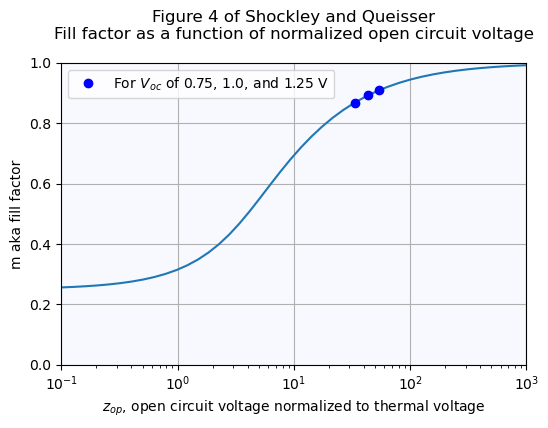

In [11]:
# Make figure 4, it is parametric in V_MPP

z_m_plot = [10**i for i in np.linspace(-2, 3)]

x_temp = [z_m + np.log(1 + z_m) for z_m in z_m_plot] 
y_temp = [(z_m**2/(1 + z_m - np.exp(-z_m)))/(z_m + np.log(1 + z_m)) for z_m in z_m_plot] 

z_m_Si = 0.75/0.025     # Should use MPP value
z_m_GaAs = 1.0/0.025
z_m_GaInP = 1.25/0.025


x_temp2 = [z_m + np.log(1 + z_m) for z_m in [z_m_Si, z_m_GaAs, z_m_GaInP ]] 
y_temp2 = [(z_m**2/(1 + z_m - np.exp(-z_m)))/(z_m + np.log(1 + z_m)) \
            for z_m in [z_m_Si, z_m_GaAs, z_m_GaInP ]] 

fig = plt.figure(figsize=(6,4), dpi=100)
plt.title('Figure 4 of Shockley and Queisser\n'
         'Fill factor as a function of normalized open circuit voltage', y=1.05)
plt.semilogx(x_temp, y_temp)
plt.semilogx(x_temp2, y_temp2, 'bo', label='For $V_{oc}$ of 0.75, 1.0, and 1.25 V')

plt.xlabel('$z_{op}$, open circuit voltage normalized to thermal voltage')
plt.ylabel('m aka fill factor')
plt.xlim(0.1, 1e3)
plt.ylim(0, 1)
plt.grid()
plt.legend(loc='best')
plt.gca().set_facecolor('ghostwhite')

**Final equation for the efficiency**

For a flat cell the detailed balance limit has $t_s = 1$ and $f = f_\omega/2$

$$\eta(x_g, x_c, t_s, f) = t_s \, u(x_g) \, v(f, x_c, x_g)\, m(v x_g/x_c) \tag{5.6}$$

with the terms meaning the following    
* $t_s$ probability that above band gap photons will produce an electron-hole pair, is 1 for the limit  
* $u(x_g)$ is ultimate effiency for a 0 K cell, a function of band gap only, eq. 2.8  
* $v(f, x_c, x_g)$ is ratio of open circuit voltage to the band gap of the absorber, eq. 3.23 
* $m(v x_g/x_c)$ is the fill factor (which they call the impendance matching factor), eq. 5.5 

## Detailed balance limit for spherical and flat cells

Recall that all the losses compared to the ultimate cell are rolled into one parameter

$$f \equiv \frac{f_c f_\omega t_s}{2 t_c} \tag{3.20}$$

There are two detailed balance cases depicted:  
* Figure 5. This is the spherical solar cell again but at 300 K ($f=1$) so it will have recombination and a well-defined open circuit voltage.   
* Figure 6. Flat solar cell, no concentration $f = f_\omega/2$. This will yield the familiar ~30% detailed balance limit. 

In [33]:
# Big class for all the calculations  

class Shockley_Queisser():
    
    """
    Put all the normalized values here
    """
    
    def x_g(self, Eg):
        """
        Bandgap scaled to black body temperature of sun
        """
        return Eg/(kB*T_sun)
        
    def x_c(self, T_cell):
        """
        Cell temperature scaled to that of the sun
        Is 0.05 for a 300 K cell and 6000 K sun
        """
        return T_cell/T_sun
    
    def V_c(self, T_cell):
        """
        Thermal voltage of cell
        """
        return kB*T_cell/q    # Is 25 mV at 300 K
    
    def V_g(self, Eg):
        """
        Band gap of cell (eV) converted to volts
        """
        return Eg/q      
        
    def z_op(self, Eg, T_cell, f):
        """
        Normalized open circuit voltage
        v is defined below
        """
        v = self.v(Eg, T_cell, f)
        x_g = self.x_g(Eg)
        x_c = self.x_c(T_cell)
        return v*x_g/x_c
        
        
    """
    now the functions
    """
    
    def Qs(self, Eg):
        """
        Photon flux above the bandgap for illumination by a black body  
        at the temperature of the sun
        """
        lower_limit = Eg/(kB*T_sun)
        upper_limit = (6*eV)/(kB*T_sun)
        factor = (2*np.pi*(kB*T_sun)**3)/(h**3*c**2)
        integral = integrate.quad(lambda x: x**2/(np.exp(x) - 1), lower_limit, upper_limit)[0]
        return factor*integral
    
    def η_ultimate(self, Eg):
        """
        Ultimate power conversion efficiency for a 0 K solar cell
        surrounded by a 6000 K blackbody
        """
        P_s = (2*np.pi**5*(kB*T_sun)**4)/(15*h**3*c**2) # Stefan Boltzmann equation
        η = (Eg*self.Qs(Eg)/P_s)
        return η
    
    def Qc(self, Eg, T_cell):
        """
        Photon flux above the bandgap for emission/absorption by a black body
        The subscript c is for the cell
        """
        lower_limit = Eg/(kB*T_cell)
        upper_limit = (6*eV)/(kB*T_cell)    # Adjusted to avoid overflow
        factor = (2*np.pi*(kB*T_cell)**3)/(h**3*c**2)
        integral = integrate.quad(lambda x: x**2/(np.exp(x) - 1), \
                                  lower_limit, upper_limit)[0]
        return factor*integral
    
    def v(self, Eg, T_cell, f):
        """
        Computes ratio of voltage at the MPP to the 
        open circuit voltage
        """
        V_c = kB*T_cell/q    # Is 25 mV at 300 K
        V_g = Eg/q           # converts eV to V
        term1 = f*self.Qs(Eg)
        term2 = self.Qc(Eg, T_cell)
        return (V_c/V_g)*np.log(term1/term2)
    
    def Fc_0(self, Eg, T_cell, Ap=1*cm**2, t_c=1):
        """
        Recombination current in the dark for a flat solar cell
        for an area Ap and probability of absorption/emission of tc
        factor of 2 is for emission from both sides of device
        """
        return 2*Ap*t_c*self.Qc(Eg, T_cell)

    def Fc(self, V, Eg, T_cell):
        """
        Recombination current as a function of cell voltage
        V is the same thing as quasi-EF splitting
        """
        Vc = (kB*T_cell)/q
        return Fc_0(Eg, T_Cell)*np.exp(V/Vc)
    
    def m(self, Eg, T_cell, f):
        """
        Computes the fill factor
        """
        x_g = self.x_g(Eg)
        x_c = self.x_c(T_cell)
        v = self.v(Eg, T_cell, f)   #V_MPP/V_oc ratio
        
        z_op = self.v(Eg, T_cell, f)*x_g/x_c     # Normalized open circuit voltage
        z_m = fsolve(lambda z_m: z_op - z_m -  np.log(1 + z_m), z_op)[0]
        term1 = z_m**2
        term2 = 1 + z_m - np.exp(-z_m)
        term3 = z_op
        return term1/(term2*term3)
    
    """Detailed balance efficiency"""
    
    def η_SQ(self, Eg, T_cell, f):
        """
        Compute efficiency
        f captures all losses
        """
        η_ultimate = self.η_ultimate(Eg)        # Ultimate effciency
        v = self.v(Eg, T_cell, f)   # V_MPP/V_oc ratio
        m = self.m(Eg, T_cell, f)
        return η_ultimate*v*m
    
    """For constructing JV curves, need J_light and J_sat"""
    
    def J_light(self, Eg, T_cell, f_ω):
        """
        Short circuit current, eq. 3.17
        but do not multiply by area so it is a current density
        Note that it is a function of f_ω not f
        """
        return q*f_ω*self.Qs(Eg)
    
    def J_sat(self, Eg, T_cell, f_c=1, t_c=1):
        """
        reverse saturation current density
        not using f at present
        factor of 2 is included above in Fc0
        """
        return q*self.Fc_0(Eg, T_cell, Ap=1*cm**2, t_c=t_c)/(1*cm**2)
    
    def V_oc(self, Eg, T_cell, f):
        """
        Open circuit voltage from Eq. 3.19 
        for a planar cell
        """
        V_c = self.V_c(T_cell)
        Q_s = self.Qs(Eg)
        Q_c = self.Qc(Eg, T_cell)
        return V_c*np.log(f*Q_s/Q_c)

model = Shockley_Queisser()

In [34]:
# Some checks
print(model.v(1.9*eV, 300, 1e-5))
print(model.Qs(1.9*eV))
print(model.Qc(1.9*eV, 300))
print(model.m(0.5*eV, 300, 1e-5))
print(model.η_SQ(1.5*eV, 300, 2e-5))

0.8410016962756811
7.974722399116945e+25
1.1431784428907143e-06
0.720040302975722
0.30180448413768596


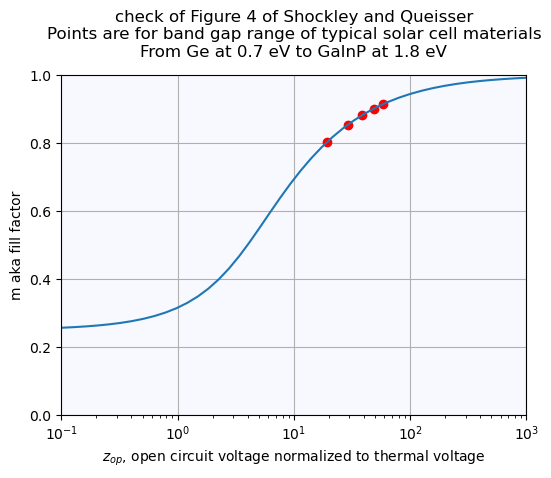

For typical solar cell materials, 1 sun limiting fill factors are in the range of 80-90%


In [14]:
# check figure 4 - 

Eg_plot = np.linspace(0.7, 1.8, 5)
plt.figure(figsize=(6,4.5), dpi=100)
plt.title('check of Figure 4 of Shockley and Queisser\n'
         'Points are for band gap range of typical solar cell materials\n'
          'From Ge at 0.7 eV to GaInP at 1.8 eV', y=1.03)
plt.figure
plt.semilogx([model.z_op(Eg*eV, 300, 2e-5) for Eg in Eg_plot],
    [model.m(Eg*eV, 300, 2e-5) for Eg in Eg_plot], 'ro')
plt.semilogx(x_temp, y_temp)
plt.xlabel('$z_{op}$, open circuit voltage normalized to thermal voltage')
plt.ylabel('m aka fill factor')
plt.xlim(0.1, 1e3)
plt.ylim(0,1)
plt.grid()
plt.gca().set_facecolor('ghostwhite')

plt.show()

print('For typical solar cell materials, 1 sun limiting fill factors are in the range of 80-90%')

In [15]:
# Cell blackbody emission fluxes
print('For a cell temperature of 300 K, calculation of Q_c')
print(f'Cell with bandgap of 1.09 eV emits {model.Qc(1.09*eV, 300*kelvin)/(cm**-2*sec**-1):.1e} photons cm^-2 s^-1')
print(f'Cell with bandgap of 1.43 eV emits {model.Qc(1.43*eV, 300*kelvin)/(cm**-2*sec**-1):.1e} photons cm^-2 s^-1')


# Radiative recombination rate
print()
print('For a flat cell at a temperature of 300 K emitting from both sides, F_c0')
print('Recombination current in the dark')
print(f'For band gap of 1.1 eV:  {model.Fc_0(1.1*eV, 300*kelvin)*q:0.2e} amp cm^-2')
print(f'For band gap of 1.4 eV:  {model.Fc_0(1.4*eV, 300*kelvin)*q:0.2e} amp cm^-2')

For a cell temperature of 300 K, calculation of Q_c
Cell with bandgap of 1.09 eV emits 1.6e+03 photons cm^-2 s^-1
Cell with bandgap of 1.43 eV emits 5.1e-03 photons cm^-2 s^-1

For a flat cell at a temperature of 300 K emitting from both sides, F_c0
Recombination current in the dark
For band gap of 1.1 eV:  3.44e-16 amp cm^-2
For band gap of 1.4 eV:  5.04e-21 amp cm^-2


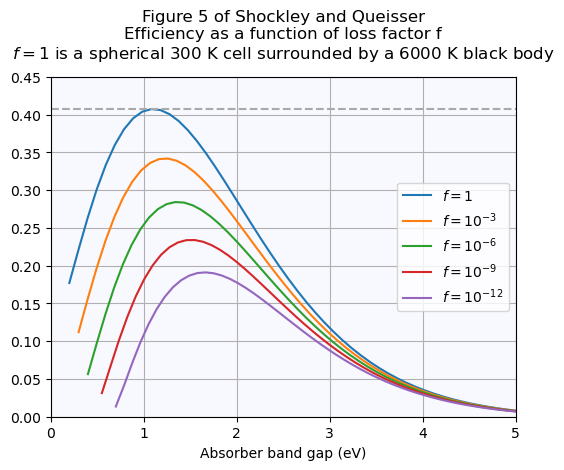

f=1 limit is 40.7% for a 300 K cell as opposed to 43.9% for the 0 K cell
Maximum is at a band gap of 1.09 eV


In [16]:
Eg_plot = np.linspace(0.65, 5, 100)
fig = plt.figure(figsize=(6,4.5), dpi=100)
plt.title('Figure 5 of Shockley and Queisser\n'
         'Efficiency as a function of loss factor f\n'
          '$f=1$ is a spherical 300 K cell surrounded by a 6000 K black body', y=1.03)
plt.plot(np.linspace(0.2,5), [model.η_SQ(Eg*eV, 300, 1) for Eg in np.linspace(0.2,5)], label="$f=1$")
plt.plot(np.linspace(0.3,5), [model.η_SQ(Eg*eV, 300, 1e-3) for Eg in np.linspace(0.3,5)], label="$f=10^{-3}$")
plt.plot(np.linspace(0.4,5), [model.η_SQ(Eg*eV, 300, 1e-6) for Eg in np.linspace(0.4,5)], label="$f=10^{-6}$")
plt.plot(np.linspace(0.55,5), [model.η_SQ(Eg*eV, 300, 1e-9) for Eg in np.linspace(0.55,5)], label="$f=10^{-9}$")
plt.plot(np.linspace(0.7,5), [model.η_SQ(Eg*eV, 300, 1e-12) for Eg in np.linspace(0.7,5)], label="$f=10^{-12}$")
plt.xlim(0, 5)
plt.xlabel('Absorber band gap (eV)')
plt.ylim(0, 0.45)
plt.axhline(y=0.407, linestyle='--', color='darkgray')
plt.gca().set_facecolor('ghostwhite')
plt.legend(loc='center right')
plt.grid()
plt.show()
print('f=1 limit is 40.7% for a 300 K cell as opposed to 43.9% for the 0 K cell')
print('Maximum is at a band gap of 1.09 eV')

In [17]:
# To get the optimal band gap
print(max([model.η_SQ(Eg*eV, 300, 1) for Eg in np.linspace(0.2,5)]))
np.argmax([model.η_SQ(Eg*eV, 300, 1) for Eg in np.linspace(0.2,5)])
np.linspace(0.2,5)[9]

0.40746570420160605


1.0816326530612244

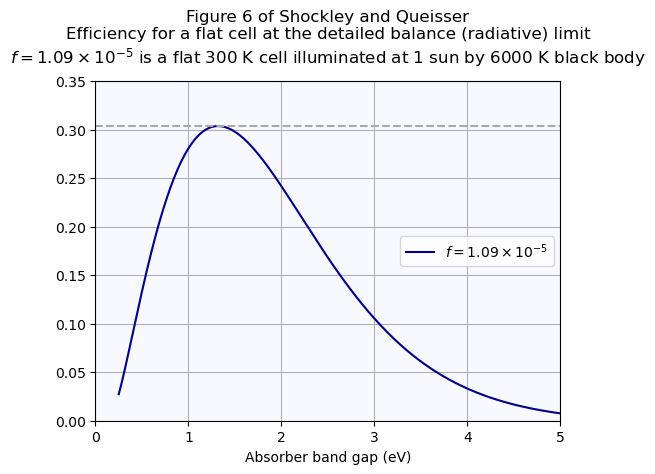

Flat cell limit is 30.3% for a 300 K cell as opposed to 43.9% for the 0 K cell
Maximum is at a band gap of 1.316 eV


In [35]:
# The famous SQ limit figure
Eg_plot = np.linspace(0.25, 5, 500)
fig = plt.figure(figsize=(6,4.5), dpi=100)
plt.title('Figure 6 of Shockley and Queisser\n'
         'Efficiency for a flat cell at the detailed balance (radiative) limit\n'
          '$f=1.09\\times 10^{-5}$ is a flat 300 K cell illuminated at 1 sun by 6000 K black body', y=1.03),
plt.plot(Eg_plot, [model.η_SQ(Eg*eV, 300, 1.09e-5) for Eg in Eg_plot], 
         'darkblue', label="$f=1.09 \\times 10^{-5}$")
plt.xlabel('Absorber band gap (eV)')
plt.xlim(0, 5)
plt.ylim(0, 0.35)
plt.axhline(y=0.30355, linestyle='--', color='darkgray')
plt.gca().set_facecolor('ghostwhite')
plt.legend(loc='center right')
plt.grid()
plt.show()
print('Flat cell limit is 30.3% for a 300 K cell as opposed to 43.9% for the 0 K cell')
print('Maximum is at a band gap of 1.316 eV')

In [24]:
print(max([model.η_SQ(Eg*eV, 300, 1.09e-5) for Eg in Eg_plot]))
np.argmax([model.η_SQ(Eg*eV, 300, 1.09e-5) for Eg in Eg_plot])
Eg_plot[112]

0.30355295360327467


1.3161322645290583

# Solar cell circuit model


$$ 
I = I_{L} + I_0 \left[\exp\left( \frac{q V}{n k_B T}\right) - 1\right]
$$


Where:  
$I_{L}$ is the light-generated current  
$n$ is the diode ideality   
$I_O$ is the reverse saturation current  

In [36]:
# Make the best SQ cell

# Note use of f_ω for illumination from one side
J_light_SQ_limit = model.J_light(1.316*eV, 300*kelvin, f_ω)
J_sat_SQ_limit = model.J_sat(1.316*eV, 300*kelvin)

print(f'J_sc = {J_light_SQ_limit/(mA*cm**-2):.02f} mA cm^-2')
print(f'J_sat = {J_sat_SQ_limit/(amp*cm**-2):.02e} A cm^-2')

J_sc = 52.09 mA cm^-2
J_sat = 1.15e-19 A cm^-2


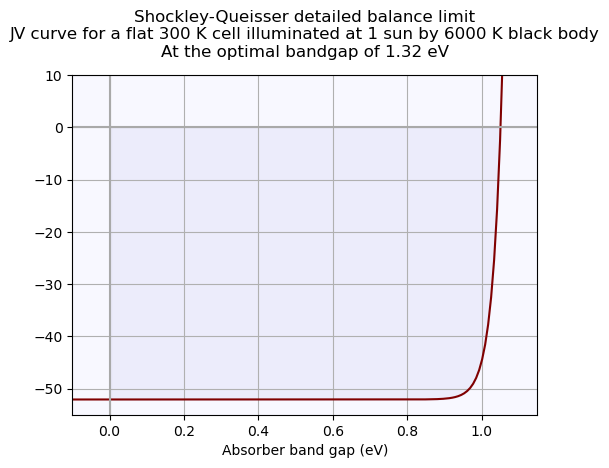

Incident power from 6000 K sun = 159.9 mW*cm^-2
Jsc = 52.09 mA*cm^-2
Voc = 1.051 V
Fill factor = 88.66%
Maximum power from cell = 48.52 mW
Efficiency = 30.35%


In [38]:
def solar_JV(V, J_light=J_light_SQ_limit, J_sat=J_sat_SQ_limit):
    return -J_light + J_sat*(np.exp(q*V/(kB*300*kelvin)) - 1)

V_plot = np.linspace(-0.1, 1.5, 200)
J_plot = [solar_JV(V)/(mA*cm**-2) for V in V_plot]

fig = plt.figure(figsize=(6,4.5), dpi=100)
plt.title('Shockley-Queisser detailed balance limit\n'
         'JV curve for a flat 300 K cell illuminated at 1 sun by 6000 K black body\n'
          'At the optimal bandgap of 1.32 eV', y=1.03),
plt.plot(V_plot, J_plot, color='maroon')
plt.fill_between(V_plot, 0, J_plot, 
                 where=([V < 1.051 and V > 0 for V in V_plot]),
                 color='lavender', alpha=0.65)
plt.xlim(-0.1, 1.15)
plt.ylim(-55, 10)
plt.xlabel('Absorber band gap (eV)')
plt.axhline(y=0.0, linestyle='-', color='darkgray')
plt.axvline(x=0.0, linestyle='-', color='darkgray')
plt.gca().set_facecolor('ghostwhite')
#plt.legend(loc='center right')
plt.grid()
plt.show()

print(f'Incident power from 6000 K sun = {P_s*f_ω/(mW*cm**-2):.01f} mW*cm^-2')
print(f'Jsc = {J_light_SQ_limit/(mA*cm**-2):.02f} mA*cm^-2')
# Note factor of 2 because radiates from both sides
print(f'Voc = {model.V_oc(1.316*eV, 300, f_ω/2):.03f} V' )
print(f'Fill factor = {100*model.m(1.316*eV, 300, f_ω/2):.02f}%')
print(f'Maximum power from cell = {max(-V*J for V, J in zip(V_plot, J_plot)):0.2f} mW')
print(f'Efficiency = {100*max(-V*J for V, J in zip(V_plot, J_plot))*mW*cm**-2/(P_s*f_ω):0.2f}%')